# Tutorial 5: Visualizing Learning

In the previous tutorial we have seen how to train an agent, but I bet that everyone of us has thought at least once "Is it really learning anything?". In this tutorial we will try to answer to that question.

We gathered again all the functions written in the previous tutorial in a script ship.py, that you can find in the Modules folder. 

## Outline
1. Online visualization: how to see how the training is doing while the agent is still training.
2. Post-training visualization: how to look at the final result.

In [1]:
#import modules and libraries
import sys
sys.path.insert(0, "../Environment/")
sys.path.insert(0, "../Modules/")
import halite_env as Env
import encode as cod
import ship 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

We redifine all variables and constants as in the previous tutorial

In [3]:
#@@@@@@@@@@@@@@@@@@@@@@
# Environment variables
#@@@@@@@@@@@@@@@@@@@@@@
NUM_PLAYERS = 1
MAP_SIZE = 7 # 7 x 7 map
TOT_TURNS = 400 # number of turns for each episode

#@@@@@@@@@@@@@@@@
# State variables
#@@@@@@@@@@@@@@@@
H_LEV = 3 # halite levels
N_CELLS = MAP_SIZE**2 # number of cells in a square map
N_STATES = N_CELLS*H_LEV**6*4
N_ACTIONS = 5 # no dropoffs, 1 action for staying still, 4 for moving in the cardinal directions
print("Total number of states to be experienced: ", N_STATES)

#@@@@@@@@@@@@@@@@@@@@
# Learning parameters
#@@@@@@@@@@@@@@@@@@@@
N_BATCH = 10 #100 # number of episodes in an epoch
MAX_EPOCHS = 200 # max number of epochs played before stopping (500 ~ 7.3 hours of training)
DISCOUNT_FACTOR = 1 - 1/TOT_TURNS #train ships as if each turn has a probability of 1/tot_turns of ending the game 
STD_REWARD = -0.01
LEARNING_RATE = 0.1
EPS_START = 0.5

Total number of states to be experienced:  142884


In [6]:
# convert all the parameters to dictionaries
env_dict = dict(NUM_PLAYERS = NUM_PLAYERS , 
                TOT_TURNS = TOT_TURNS)

state_dict = dict(MAP_SIZE = MAP_SIZE,  
                  H_LEV = H_LEV, 
                  N_ACTIONS = N_ACTIONS)

learning_dict = dict(LEARNING_RATE = LEARNING_RATE, 
                     DISCOUNT_FACTOR = DISCOUNT_FACTOR , 
                     eps = EPS_START, 
                     STD_REWARD = STD_REWARD)

In [4]:
#@@@@@@@@@@@@@@@@@@@
# Learning variables
#@@@@@@@@@@@@@@@@@@@
q_values = np.zeros((N_STATES,N_ACTIONS)) #initialize to zero
#q_values = np.load("Q_values.npy") # or re-use the one already trained

## Online visualization

The online visualization is based on two ideas: to find some metrics to monitor and to monitor them almost in real time.

One of the obvious metrics that we measured in the previous tutorial was the return at the end of the episode.
Another one directly connected to that, but with a more practical touch, is the halite collected from the agent during the episode.

And finally we would like to know how many time the ship passes through the shipyard, since it is a good indicator of what is going on.

Thus we now modify the play_episode function written in the previous tutorial in order to make it compute those quantities.

In [30]:
def play_episode(q_values, eps, NUM_PLAYERS, MAP_SIZE, TOT_TURNS, N_ACTIONS, H_LEV,
                 STD_REWARD,LEARNING_RATE, DISCOUNT_FACTOR, verbose = False):
    """
    Trains the agent by playing one episode of halite.
    
    Parameters
    ----------
    q_values         : numpy array 
        Contains the Q-values
    eps              : float 
        Represents a probability, must be in [0,1], controls the probability of exploring instead of exploting
    NUM_PLAYERS      : int
    MAP_SIZE         : int
    TOT_TURNS        : int
    N_ACTIONS        : int
    H_LEV            : int
    STD_REWARD       : float
        Baseline reward given to the agent when does not deposit halite to the shipyard
    LEARNING_RATE    : float
    DISCOUNT_FACTOR  : float
        Must be greater than 0 but smaller than 1. Suggested 1-1/TOT_TURNS or 1
    verbose          : bool
        Prints halite of the player at each turn of the game
        
    Returns
    -------
    q_values         : numpy array 
        Updated Q-values
    reward           : float
        Reward obtained in this episode. 
    collected_halite : float
        Halite collected by the agent.
    passages         : int
        Number of passages of the ship through the shipyard.
    """
    env = Env.HaliteEnv(NUM_PLAYERS, MAP_SIZE, episode_lenght = TOT_TURNS) # init environment
    steps = 0
    reward = 0 # cumulative reward of the episode
    passages = 0 # number of times the ship passes through the shipyard
    
    # first mandatory step
    steps = steps + 1
    if verbose:
        print("\nStep number %d:"%steps)
    action_matrix = np.full((MAP_SIZE,MAP_SIZE), -1) # no ship, no action
    shipyard_action = True # initially always choose to create a ship
    # returns the matricial state, the array of players halite and a flag that is true if it's the final turn
    state, players_halite, finish, _ = env.step(action_matrix, makeship = shipyard_action) 
    #print("Cargo layer: \n", state[:,:,2])
    current_halite = players_halite[0][0]
    s_enc = cod.encode_state(state, map_size = MAP_SIZE, h_lev = H_LEV, n_actions = N_ACTIONS, debug=False)

    while True:
        steps = steps + 1
        if verbose:
            print("\nStep number %d:"%steps)
            print("Current halite: ", current_halite)
        a_enc = ship.e_greedy_policy(s_enc, q_values, eps = eps)
        a_mat = cod.scalar_to_matrix_action(a_enc, state, map_size = MAP_SIZE) #convert the action in matricial form

        # submit the action and get the new state
        state, players_halite, finish, _ = env.step(a_mat, makeship = False) 

        new_halite = players_halite[0][0]

        # compute the 1-ship reward as the halite increment of the player divided by the max halite 
        # plus a standard negative reward 
        r = (new_halite - current_halite)/1000 + STD_REWARD

        sp_enc = cod.encode_state(state, map_size = MAP_SIZE, h_lev = H_LEV, n_actions = N_ACTIONS, debug=False)
        reward += r # cumulative reward of the episode

        # adds 1 to passages if the current position of the ship coincides with that of the shipyard
        # whereas the previous position didn't
        s_dec = cod.decode3D(s_enc, L1 = MAP_SIZE**2, L2 = H_LEV**6, L3 = N_ACTIONS-1)
        sp_dec = cod.decode3D(sp_enc, L1 = MAP_SIZE**2, L2 = H_LEV**6, L3 = N_ACTIONS-1)
        shipy_pos = (MAP_SIZE**2-1)/2 #shipyard is at the center of the map
        if (sp_dec[0] == shipy_pos and s_dec[0] != shipy_pos):
            passages = passages +1
                
        a_temp_enc = ship.greedy_policy(sp_enc, q_values) # simulate the best action in the new state (before update)

        # update Q-values
        q_values = ship.update_q_v1(s_enc, a_enc, r, sp_enc, a_temp_enc, q_values, alpha = LEARNING_RATE,
                    gamma = DISCOUNT_FACTOR, map_size = MAP_SIZE, h_lev = H_LEV, n_actions = N_ACTIONS)

        # update states and halite
        s_enc = sp_enc
        current_halite = new_halite

        if (finish == True) or (steps >= 400):
            if verbose:
                print("\nEnd episode.")
            break
    collected_halite = current_halite - 4000
    return q_values, reward, collected_halite, passages

To skip a passage I already copied this function in the ship.py script in the Modules folder.

In [37]:
q_values, reward, collected_halite, passages = ship.play_episode(q_values, verbose = True, **env_dict, **state_dict, **learning_dict)


Step number 1:

Step number 2:
Current halite:  4000.0

Step number 3:
Current halite:  4000.0

Step number 4:
Current halite:  4000.0

Step number 5:
Current halite:  4000.0

Step number 6:
Current halite:  4000.0

Step number 7:
Current halite:  4000.0

Step number 8:
Current halite:  4000.0

Step number 9:
Current halite:  4000.0

Step number 10:
Current halite:  4000.0

Step number 11:
Current halite:  4000.0

Step number 12:
Current halite:  4000.0

Step number 13:
Current halite:  4000.0

Step number 14:
Current halite:  4000.0

Step number 15:
Current halite:  4000.0

Step number 16:
Current halite:  4000.0

Step number 17:
Current halite:  4000.0

Step number 18:
Current halite:  4000.0

Step number 19:
Current halite:  4199.0

Step number 20:
Current halite:  4199.0

Step number 21:
Current halite:  4199.0

Step number 22:
Current halite:  4419.0

Step number 23:
Current halite:  4419.0

Step number 24:
Current halite:  4419.0

Step number 25:
Current halite:  4419.0

Step nu


Step number 209:
Current halite:  6550.0

Step number 210:
Current halite:  6550.0

Step number 211:
Current halite:  6550.0

Step number 212:
Current halite:  6550.0

Step number 213:
Current halite:  6550.0

Step number 214:
Current halite:  6550.0

Step number 215:
Current halite:  6550.0

Step number 216:
Current halite:  6550.0

Step number 217:
Current halite:  6550.0

Step number 218:
Current halite:  6550.0

Step number 219:
Current halite:  6550.0

Step number 220:
Current halite:  6550.0

Step number 221:
Current halite:  6550.0

Step number 222:
Current halite:  6550.0

Step number 223:
Current halite:  6550.0

Step number 224:
Current halite:  6550.0

Step number 225:
Current halite:  6550.0

Step number 226:
Current halite:  6550.0

Step number 227:
Current halite:  6550.0

Step number 228:
Current halite:  6550.0

Step number 229:
Current halite:  6550.0

Step number 230:
Current halite:  6550.0

Step number 231:
Current halite:  6550.0

Step number 232:
Current halite: 

In [38]:
print("Reward: %.4f \nCollected halite : %.0f \nPassages through shipyard: %d"%(reward, collected_halite, passages))

Reward: -0.2840 
Collected halite : 3706 
Passages through shipyard: 16


Now we want to plot this quantities in real time during the training.

<IPython.core.display.Javascript object>


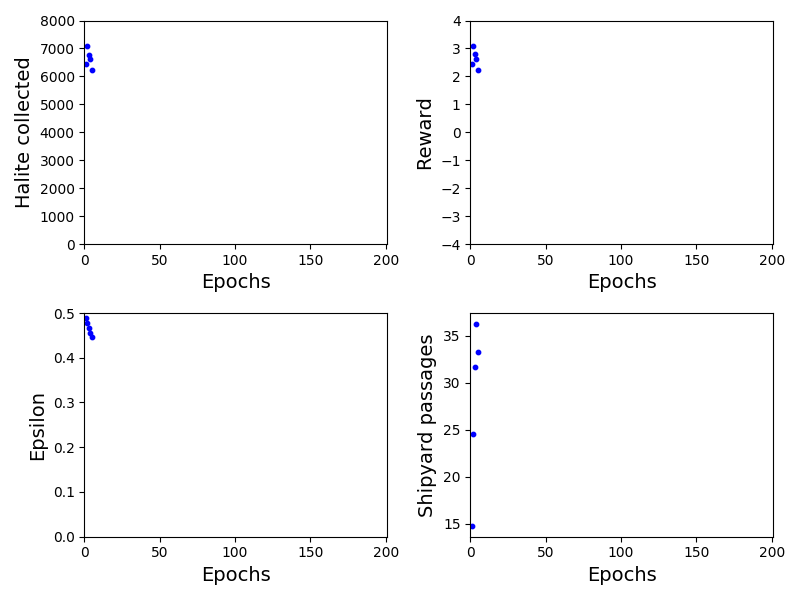

KeyboardInterrupt: 

In [41]:
#@@@@@@@@@@@@@@@@@@@
# Learning variables
#@@@@@@@@@@@@@@@@@@@
q_values = np.zeros((N_STATES,N_ACTIONS)) #initialize to zero
#q_values = np.load("Q_values.npy") # or re-use the one already trained
reward_score = np.zeros(MAX_EPOCHS)
halite_score = np.zeros(MAX_EPOCHS)
shipy_pass = np.zeros(MAX_EPOCHS)
epochs = 0
eps = EPS_START # starting value of epsilon
# generate an adaptive epsilon greedy algorithm, calibrated in order to have epsilon = 10^-4 at the last epoch
epsilons = np.array(list(map(lambda i : eps*np.exp(-i*2*np.log(10)/MAX_EPOCHS), np.arange(0,MAX_EPOCHS+1))))


# visualize online the results
%matplotlib notebook
fig = plt.figure(figsize = (8,6))
plt.ion()

ax1 = fig.add_subplot(221)
ax1.set_xlim(0,MAX_EPOCHS+1)
ax1.set_ylim(0,8000)
ax1.set_xlabel("Epochs", fontsize = 14)
ax1.set_ylabel("Halite collected", fontsize = 14)

ax2 = fig.add_subplot(222)
ax2.set_xlim(0,MAX_EPOCHS+1)
ax2.set_ylim(-4,4)
ax2.set_xlabel("Epochs", fontsize = 14)
ax2.set_ylabel("Reward", fontsize = 14)


ax3 = fig.add_subplot(223)
ax3.set_xlim(0,MAX_EPOCHS+1)
ax3.set_ylim(0,0.5)
ax3.set_xlabel("Epochs", fontsize = 14)
ax3.set_ylabel("Epsilon", fontsize = 14)


ax4 = fig.add_subplot(224)
ax4.set_xlim(0,MAX_EPOCHS+1)
ax4.set_xlabel("Epochs", fontsize = 14)
ax4.set_ylabel("Shipyard passages", fontsize = 14)

plt.tight_layout()
fig.show()
fig.canvas.draw()

from tqdm import tnrange

for k in tnrange(MAX_EPOCHS):
    #@@@@@@@@@@@@@@@@@@@@@@
    # here starts an epoch
    #@@@@@@@@@@@@@@@@@@@@@@
    epochs = epochs + 1
    reward_progress = np.zeros(N_BATCH) # bunch of 100 episodes
    halite_progress = np.zeros(N_BATCH) # bunch of 100 episodes
    shipy_pass_progress = np.zeros(N_BATCH) # bunch of 100 episodes
    eps = epsilons[epochs]
    # update the dictionary at each epoch with the new epsilon
    learning_dict = dict(LEARNING_RATE = 0.1, DISCOUNT_FACTOR = DISCOUNT_FACTOR , eps = eps, STD_REWARD = STD_REWARD)

    for i in tnrange(N_BATCH):
        # here starts an episode
        q_values, reward, collected_halite, passages = play_episode(q_values, **env_dict, **state_dict, **learning_dict)
        reward_progress[i] = reward
        halite_progress[i] = collected_halite
        shipy_pass_progress[i] = passages

        #break # play just 1 episode

    #break # play just 1 epoch

    reward_score[epochs-1] = reward_progress.mean()
    halite_score[epochs-1] = halite_progress.mean()
    shipy_pass[epochs-1] = shipy_pass_progress.mean()
    
    ax1.scatter(epochs, halite_score[epochs-1], s = 10, color='blue')
    ax2.scatter(epochs, reward_score[epochs-1], s = 10,color='blue')
    ax3.scatter(epochs, epsilons[epochs], s = 10, color='blue')
    ax4.scatter(epochs, shipy_pass[epochs-1], s = 10, color='blue')
    fig.canvas.draw()

    if epochs >= MAX_EPOCHS:
        print("Hey, I think you've had enough! Let's stop here.")
        break